In [1]:
#Library

import subprocess
import sys
import importlib.util

def check_and_install(package):
    """
        This function checks if a package is installed and installs it if not.
    """

    if importlib.util.find_spec(package) is None:
        print(f"{package} not found, installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"{package} has been installed")
    
# List of packages to check, with any special names or setup functions
packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "scipy",
    "xgboost",
    "lightgbm",
    "tqdm",
    "ipywidgets",
    "pandarallel",
    "plotly",

]

# Loop through each package, importing and installing if needed
for package in packages:
    check_and_install(package)


import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import multivariate_normal
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler 



scikit-learn not found, installing...
scikit-learn has been installed


In [2]:
#Dataset import on pandas Data frames
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races.csv")

# Drop redundant columns
# _url from DatasetCyclist this information is in DatasetRace under the column 'cyclist'
# name from DatasetRace this information is in DatasetCyclist under the column 'name'
MergedDataset = pd.merge(DatasetCyclists, DatasetRace.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 

MergedDataset.head(10)

,name,birth_year,weight,height,nationality,_url_race,points,uci_points,length,climb_total,...,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,Bruno Surra,1964.0,NaN,NaN,Italy,vuelta-a-espana/1989/stage-1,80.0,NaN,20100.0,588.0,...,NaN,1989-04-24 00:25:33,110,bruno-surra,25.0,True,False,False,NaN,15.0
1,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1997/stage-2,100.0,NaN,262000.0,2808.0,...,NaN,1997-07-07 06:27:47,132,gerard-rue,32.0,True,False,False,denmark-1991,0.0
2,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1990/stage-1,100.0,NaN,138500.0,1232.0,...,NaN,1990-07-01 03:29:36,66,gerard-rue,25.0,True,False,False,france-1978,635.0
3,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1992/stage-7,100.0,NaN,196500.0,2010.0,...,NaN,1992-07-11 04:22:52,35,gerard-rue,27.0,True,False,False,france-1978,65.0
4,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1990/stage-9,100.0,NaN,196000.0,2381.0,...,NaN,1990-07-09 04:46:44,41,gerard-rue,25.0,True,False,False,france-1978,37.0
5,Gérard Rué,1965.0,74.0,182.0,France,la-fleche-wallone/1996/result,225.0,NaN,200500.0,NaN,...,NaN,1996-04-17 04:42:20,35,gerard-rue,31.0,False,False,False,czechoslovakia-1987,140.0
6,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1991/stage-12,100.0,NaN,192000.0,4000.0,...,NaN,1991-07-18 05:22:47,10,gerard-rue,26.0,True,False,False,norway-1987,415.0
7,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1989/stage-17,100.0,NaN,165000.0,5000.0,...,NaN,1989-07-19 05:18:23,24,gerard-rue,24.0,True,False,False,carrera-inoxpran-1985,464.0
8,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1997/stage-5,100.0,NaN,261300.0,2212.0,...,NaN,1997-07-10 06:20:08,108,gerard-rue,32.0,True,False,False,denmark-1991,204.0
9,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1992/stage-15,100.0,NaN,198000.0,2662.0,...,NaN,1992-07-20 04:45:19,29,gerard-rue,27.0,True,False,False,france-1978,80.0


### Plot tools

In [118]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [119]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

# **Data understanding**

## Dataset cyclists

### Missing values distributions

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134            3056           3078
height               6134            2991           3143
nationality          6134               1           6133


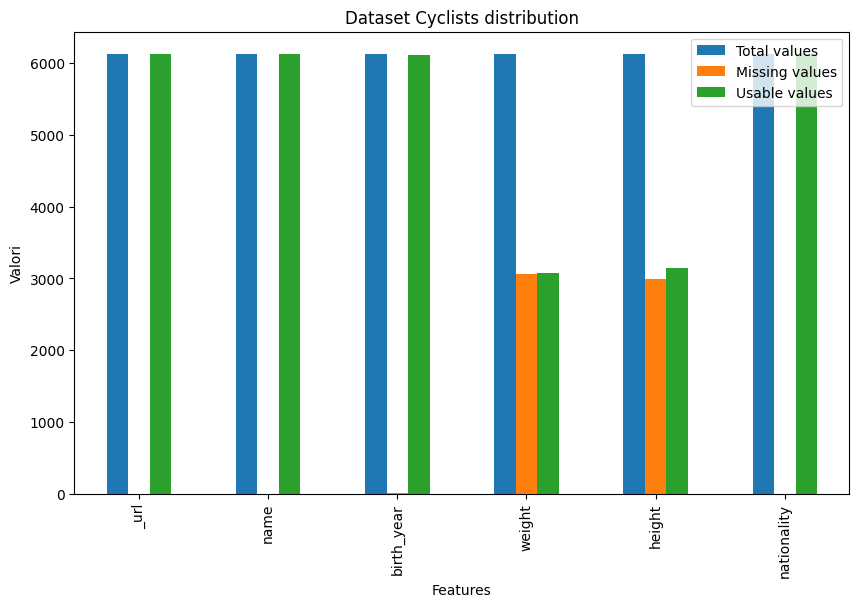

In [120]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

### Features distributions

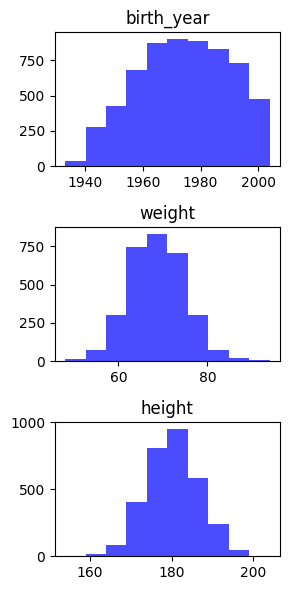

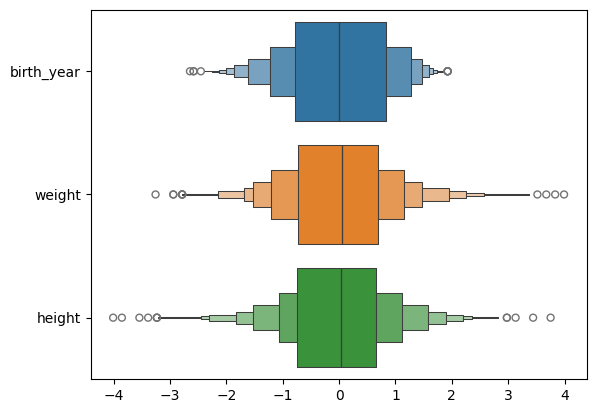

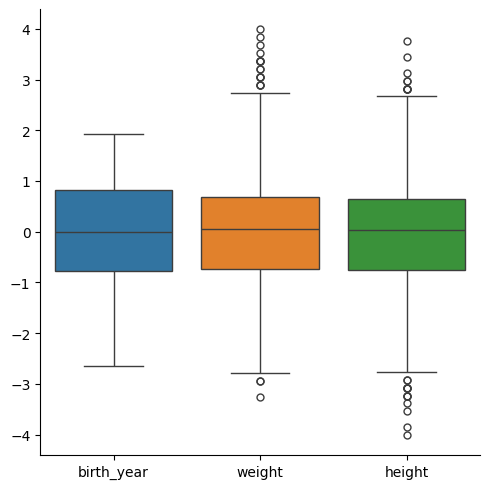

In [121]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Correlations between features (Oleskiy)

What follows are the most important relationships between features, in my opinion, to show.
To see a complete analysis go to file [OleksiyRelFeature.ipynb](OleksiyRelFeature.ipynb)

#### Begin the analysis with a correlation matrix

Let's begin the analysis with a big correlation matrix that contains all the significant features from the `DatasetCyclists` and `DatasetRaces` frames.

`

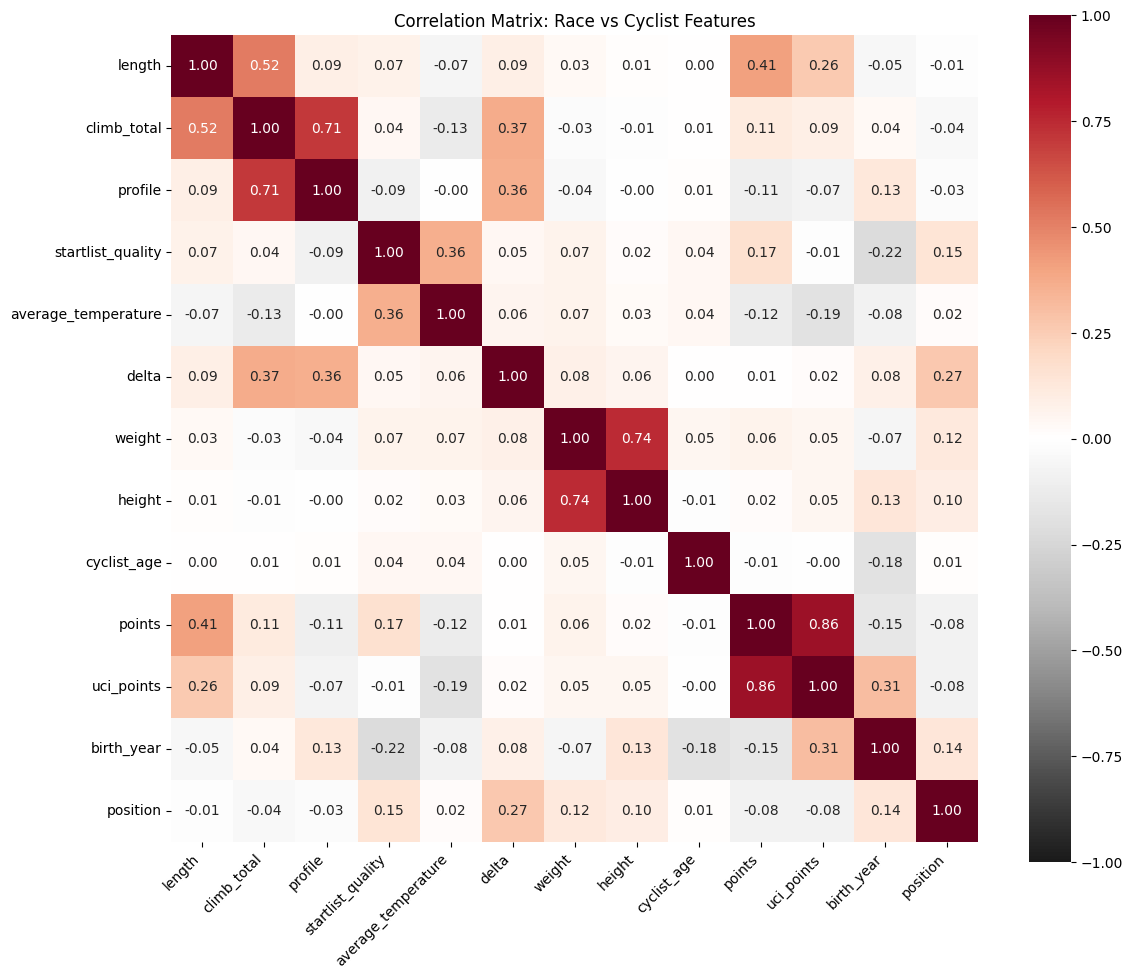

In [3]:
columns_of_interest = [
        'length', 'climb_total', 'profile', 'startlist_quality', 
        'average_temperature', 'delta', 'weight', 'height', 
        'cyclist_age', 'points', 'uci_points', 'birth_year', 'position'
]

def create_correlation_matrix(merged_df, columns_of_interest=columns_of_interest):
    # Select the relevant columns from the correlation matrix shown in the image
    
    
    # Create a copy of races dataframe with selected columns
    race_data = merged_df[columns_of_interest].copy()
    
    # Calculate correlation matrix
    corr_matrix = race_data.corr(method='pearson')
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    seaborn.heatmap(corr_matrix, 
                annot=True,  # Show correlation values
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdGy_r',  # Red-Grey-Blue colormap reversed
                vmin=-1,     # Minimum correlation value
                vmax=1,      # Maximum correlation value
                center=0,    # Center the colormap at 0
                square=True) # Make the plot square-shaped
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add title
    plt.title('Correlation Matrix: Race vs Cyclist Features')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf(), corr_matrix


fig,corr_matrix = create_correlation_matrix(merged_df=MergedDataset)
plt.show()
plt.close(fig)


#### Since the best correlations might be hard to see, I will show below the top 6 positive and negative ones.


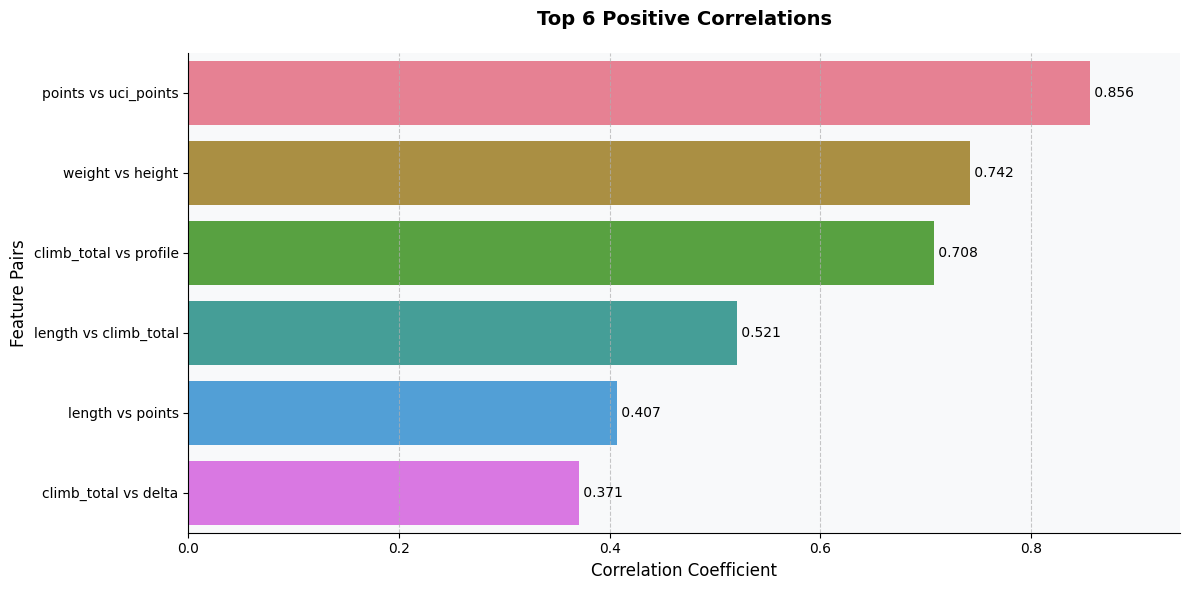

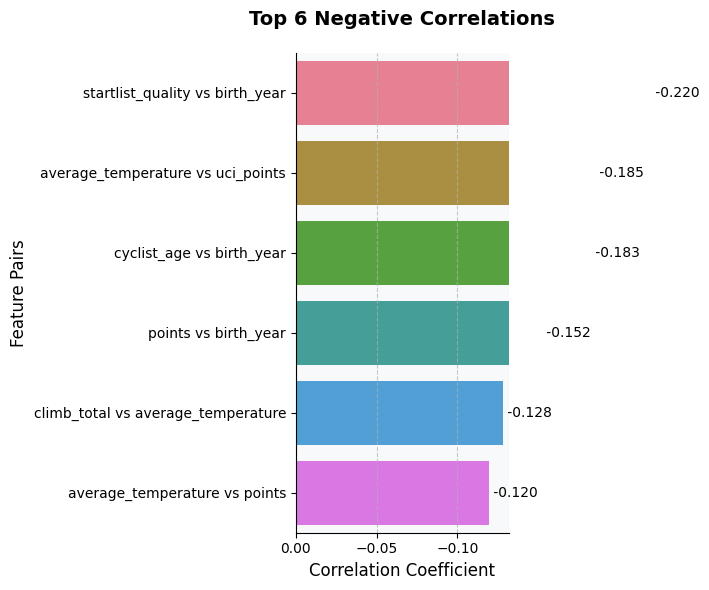

In [4]:
def display_top_correlations(corr_matrix, n=6):
    # Get upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    
    # Stack the correlations and sort by absolute value
    stacked = upper.stack()
    sorted_corr = stacked.loc[stacked.sort_values(ascending=False).index]
    correlations = {
        "Positive": {
            "Features Pair": [],
            "Correlation": []
        },
        "Negative": {
            "Features Pair": [],
            "Correlation": []
        }
    }
    for i in range(min(n, len(sorted_corr))):
        # pair = sorted_corr.index[i]
        # value = sorted_corr.iloc[i]
        # print(f"{pair[0]} vs {pair[1]}: {value:.3f}")
        correlations["Positive"]["Features Pair"].append(f"{sorted_corr.index[i][0]} vs {sorted_corr.index[i][1]}")
        correlations["Positive"]["Correlation"].append(sorted_corr.iloc[i])
        correlations["Negative"]["Features Pair"].append(f"{sorted_corr.index[-(i+1)][0]} vs {sorted_corr.index[-(i+1)][1]}")
        correlations["Negative"]["Correlation"].append(sorted_corr.iloc[-(i+1)])
    
    return pd.DataFrame(correlations["Positive"]), pd.DataFrame(correlations["Negative"])
        
def print_abs_top_correlations(df, message):
    # Create horizontal bar chart
    

    seaborn.set_palette("husl")

    # Create the figure and axis with a specific size
    fig, ax = plt.subplots(figsize=(12, 6))

    seaborn.barplot(
        data=df,
        y='Features Pair',
        x='Correlation',
        ax=ax,
        hue='Features Pair',  # This gives each bar a unique color
        legend=False  # Don't show the legend since it's redundant
    )

    # Customize the plot
    ax.set_title(message, pad=20, fontsize=14, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient', fontsize=12)
    ax.set_ylabel('Feature Pairs', fontsize=12)

    # Add value labels on the bars
    for i, v in enumerate(df['Correlation']):
        ax.text(v, i, f' {v:.3f}', va='center', fontsize=10)

    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Set the x-axis limits to make it visually appealing
    ax.set_xlim(0, max(df['Correlation']) * 1.1)

    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linewidth=0.5)

    # Customize the background
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')

    # Remove top and right spines
    seaborn.despine()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()
    plt.close()

dfs = display_top_correlations(corr_matrix)

# Create the figure and axis with a specific size
print_abs_top_correlations(dfs[0], "Top 6 Positive Correlations")
print_abs_top_correlations(dfs[1], "Top 6 Negative Correlations")






#### Comments on the positive correlations
There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.

#### Comments on the negative correlations

There is a small correlation between the ```startlist_quality``` feature and the birth_year, which might suggest that if the race has many young riders, it will have lower `startlist_quality`. The negative correlation between points and `birth_year` makes sense since younger cyclists tend to have fewer `points`.

There is a slightly negative correlation between the `average_temperature` and `uci_points` that can be further investigated.


#### `weight`, `height` and race `profile` influence the `position`? 

Let's see if the `weight` and `height` of the riders, coupled with the race `profile`, influence the position of the cyclist.

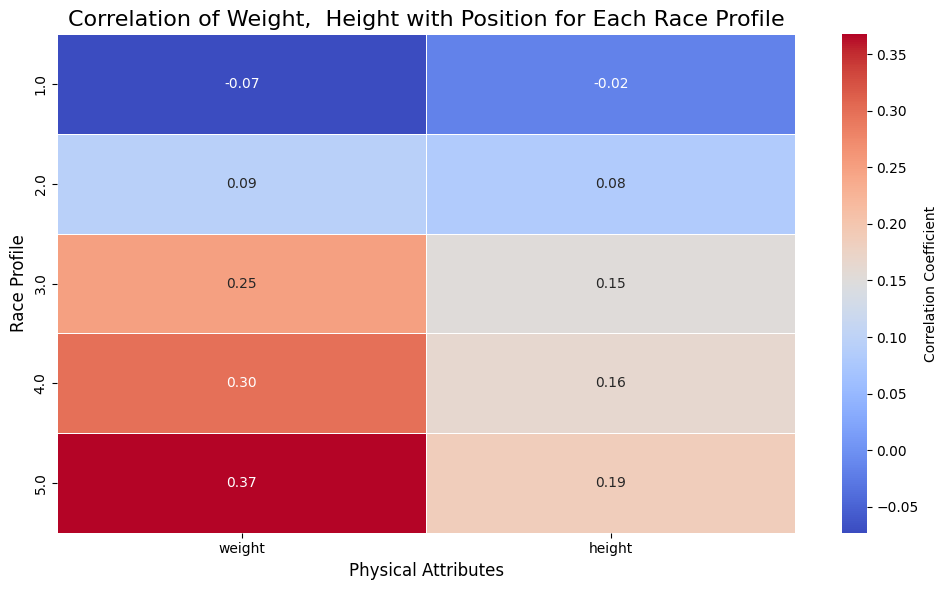

In [5]:
whpp_cor_feat = ['weight', 'height', 'position', 'profile']
whpp_cor_df = MergedDataset[whpp_cor_feat].copy()

correlations = whpp_cor_df.groupby('profile')[['weight', 'height', 'position']].corr()

correlations = correlations.xs('position', level=1).drop('position', axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = seaborn.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Customize the heatmap
heatmap.set_title('Correlation of Weight,  Height with Position for Each Race Profile', fontsize=16)
heatmap.set_xlabel('Physical Attributes', fontsize=12)
heatmap.set_ylabel('Race Profile', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()
del whpp_cor_df

It clearly shows that lighter riders tend to finish in better positions when the climbing is significant, which makes perfect sense. The height has a smaller correlation, but we can still say that height might influence the final position of the rider if the race has a high profile.

#### Correlation between `average_temperature`, `nationality`, and `age_group`

Even though the `average_temperature` column has many `NaN` values, it is interesting to examine the mentioned correlations.



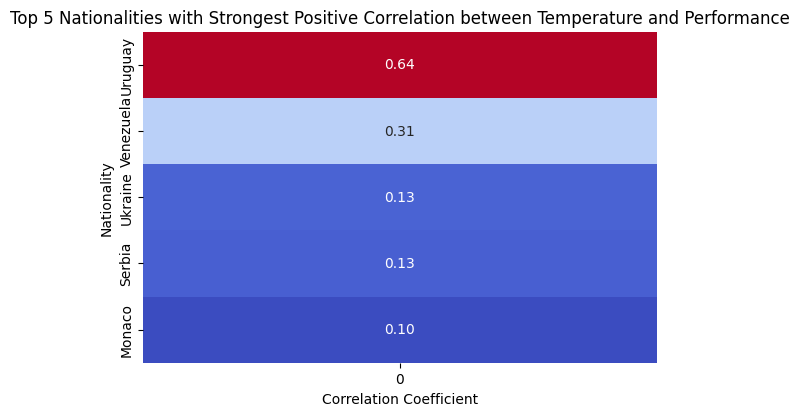

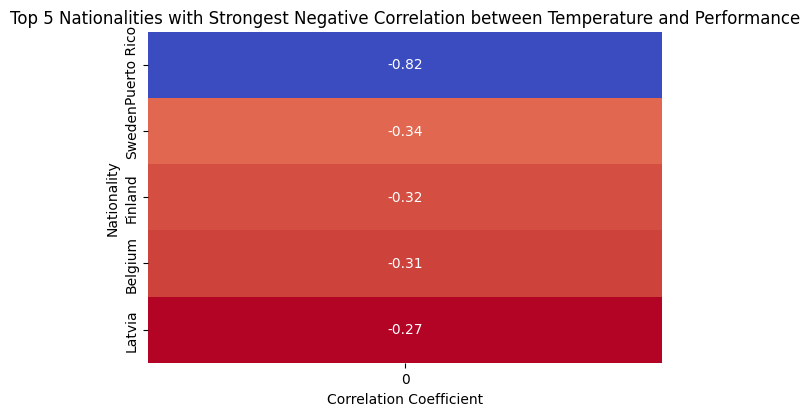

In [7]:
def calc_group_correlations(data, group_column):
    correlations = {}
    for group in data[group_column].unique():
        group_data = data[data[group_column] == group]
        if len(group_data) > 1:  # Ensure we have enough data points
            if group_data['average_temperature'].nunique() > 1 and group_data['average_temperature'].std() > 0 and group_data['points'].std() > 0:  # Ensure temperature varies
                corr, _ = stats.pearsonr(group_data['average_temperature'], group_data['points'])
                correlations[group] = corr
    return pd.Series(correlations)

ana_cor_feat = ['average_temperature', 'points', 'uci_points', 'position', 'nationality', 'cyclist_age']
ana_cor_df = MergedDataset[ana_cor_feat].copy()

# where uci_points is not null and position is null insert insert uci_points in position
ana_cor_df['position'] = ana_cor_df['position'].fillna(ana_cor_df['uci_points'])
ana_cor_df.dropna(subset=['points', 'average_temperature'], inplace=True)

nationality_correlations = calc_group_correlations(ana_cor_df, 'nationality')

heatmap_data = nationality_correlations.nlargest(5).to_frame()


heatmap = seaborn.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Positive Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()

heatmap = seaborn.heatmap(nationality_correlations.nsmallest(5).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Negative Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()


As the correlation shows, riders coming from warmer countries may perform better in higher temperatures. In contrast, athletes from colder countries might struggle as temperatures rise. The outlier here is Puerto Rico, which could be interesting to investigate further.

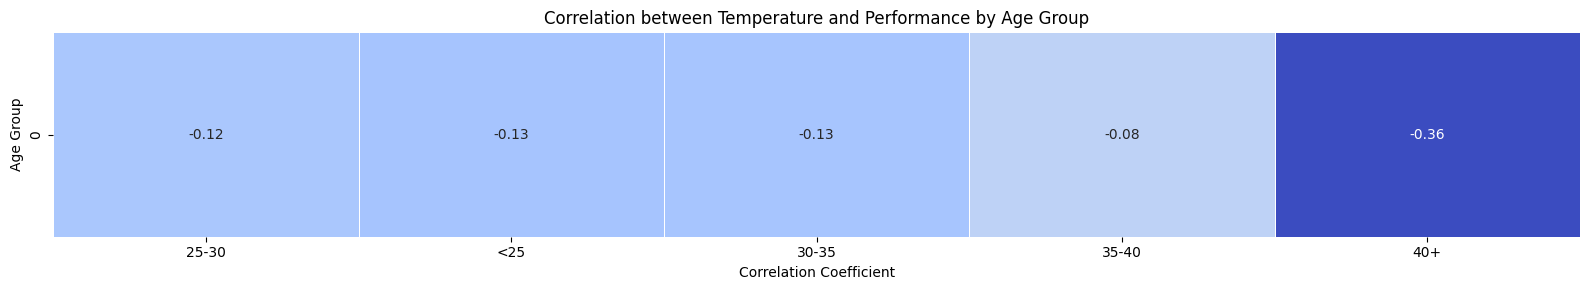

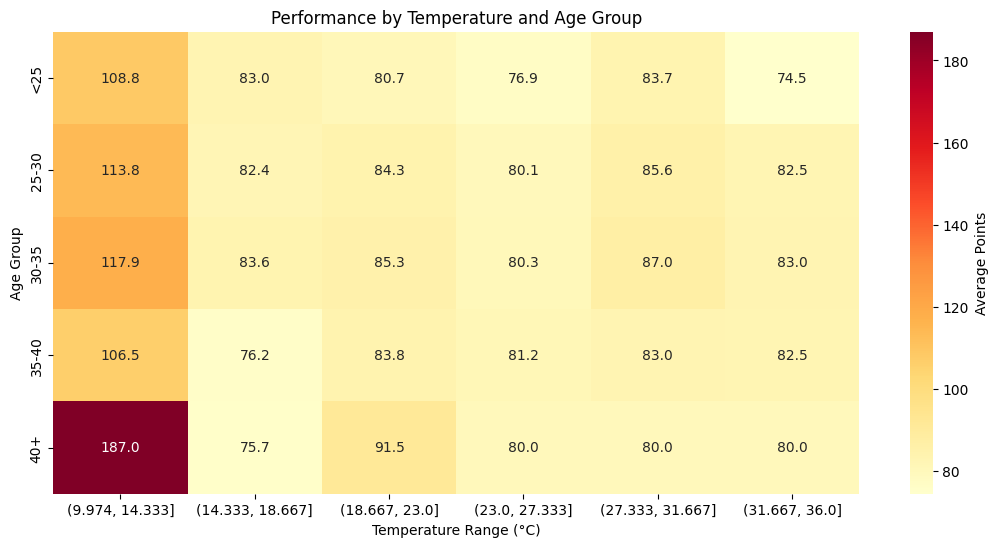

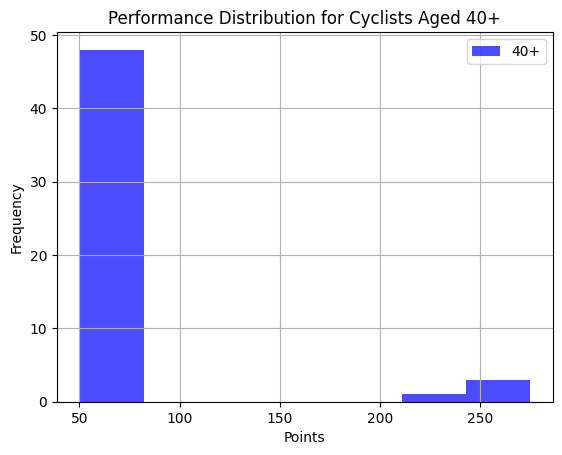

In [8]:
plt.figure(figsize=(16, 3))
ana_cor_df['age_group'] = pd.cut(ana_cor_df['cyclist_age'], bins=[0, 25, 30, 35, 40, 100], labels=['<25', '25-30', '30-35', '35-40', '40+'])
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
age_group_correlations = calc_group_correlations(ana_cor_df, 'age_group')

heatmap = seaborn.heatmap(age_group_correlations.to_frame().T, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f", cbar=False)
heatmap.set_title('Correlation between Temperature and Performance by Age Group')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Age Group')

plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(13, 6))
pivot = ana_cor_df.pivot_table(values='points', index='age_group', observed=True, columns=pd.cut(ana_cor_df['average_temperature'], bins=6), aggfunc='mean')
seaborn.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', cbar_kws={'label': 'Average Points'})
plt.title('Performance by Temperature and Age Group')
plt.xlabel('Temperature Range (°C)')
plt.ylabel('Age Group')
plt.show()
plt.close()
ana_cor_df[ana_cor_df['age_group'] == '40+']['points'].hist(bins='auto', alpha=0.7, color='blue', label='40+')
plt.title('Performance Distribution for Cyclists Aged 40+')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend()
plt.show()
plt.close()

del ana_cor_df


The correlation between temperature and age groups might suggest that the older the rider, the stronger the temperature influences the rider's performance. However, as we can see in the second figure, there is an anomalously high average points in the colder temperature range for the 40+ age group, which might indicate outliers. Moreover, the histogram clearly shows that these are outliers due to their frequency.

### Cyclist's Career Span

Next, we will see the career span of top cyclists and how age influences their performance.


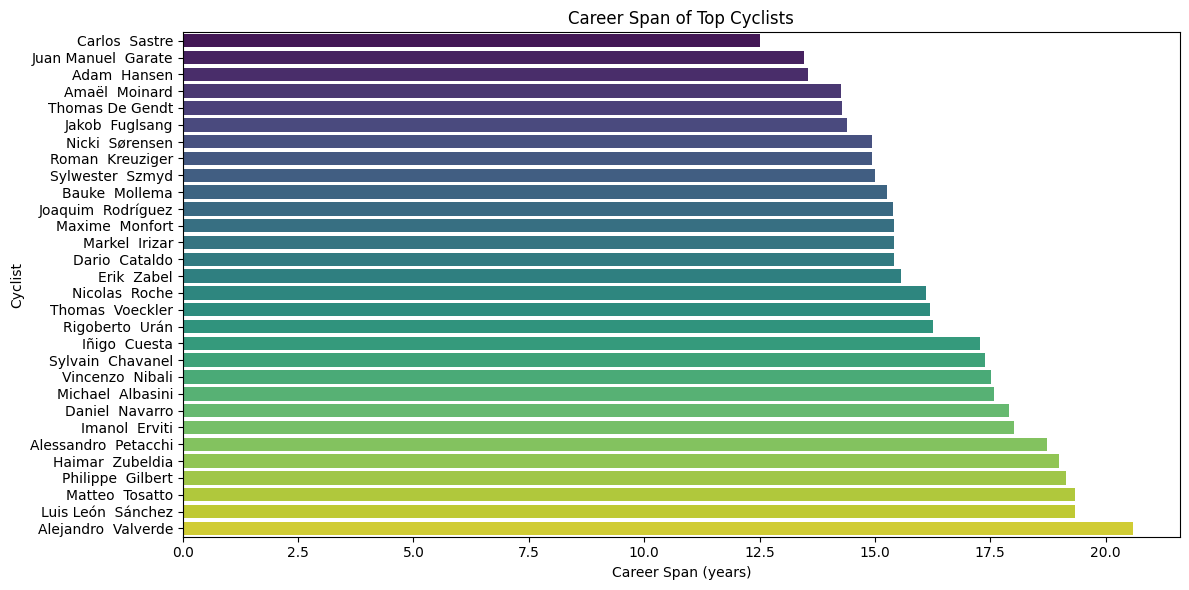

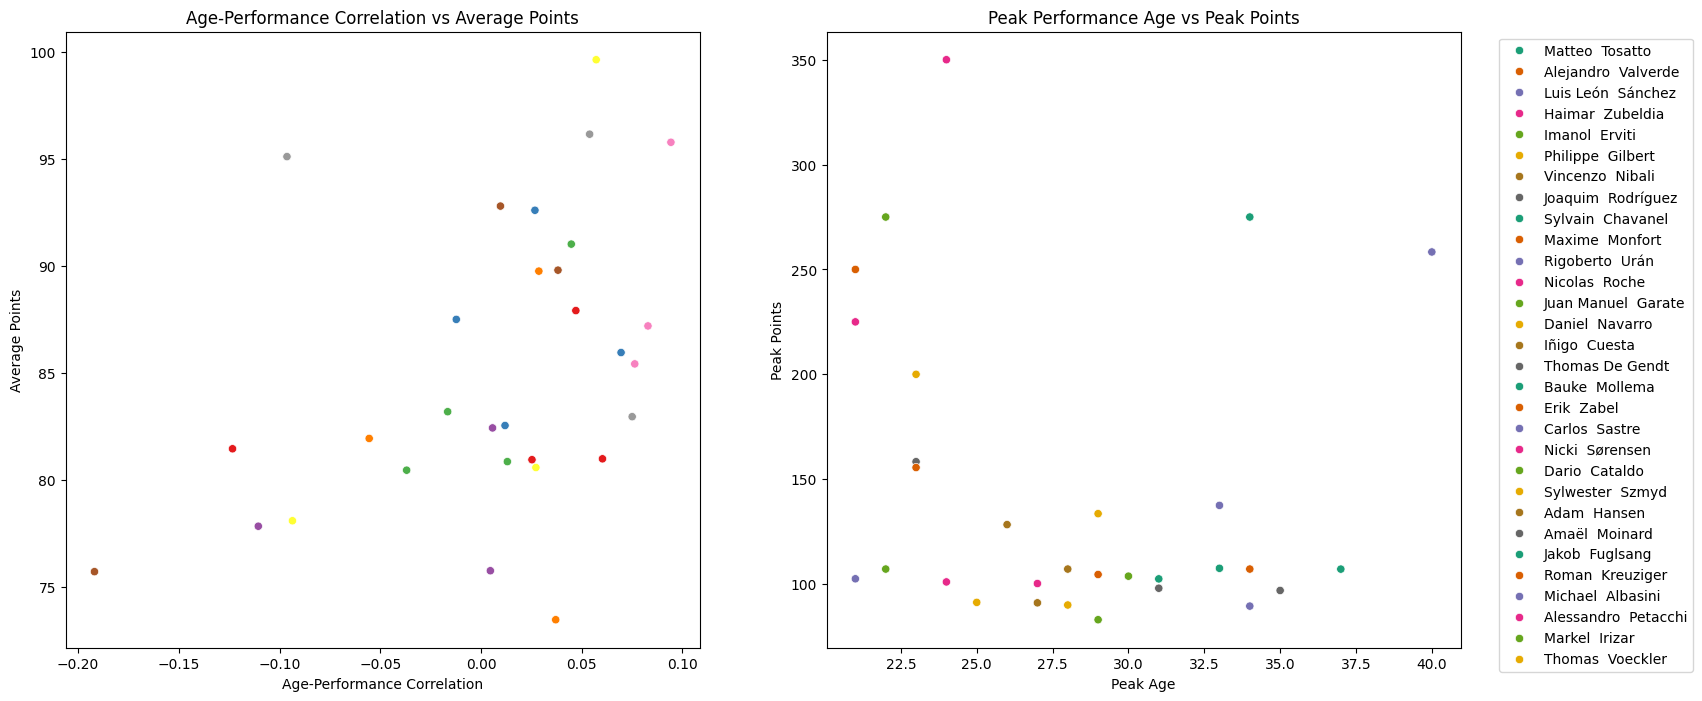

In [138]:
def analyze_cyclist_progression(cyclist_name, data, min_races=10, plot=True):
    cyclist_data = data[data['cyclist'] == cyclist_name].sort_values('date')
    
    if len(cyclist_data) < min_races:
        #print(f"{cyclist_name} has fewer than {min_races} races. Skipping.")
        return None
    
    # Calculate a rolling average of points
    cyclist_data['rolling_avg_points'] = cyclist_data['points'].rolling(window=10, min_periods=1).mean()
    if plot:
        # Plot the first
        # Plot career progression
        plt.figure(figsize=(12, 6))
        plt.plot(cyclist_data['date'], cyclist_data['rolling_avg_points'], label='Rolling Avg Points (10 races)')
        plt.scatter(cyclist_data['date'], cyclist_data['points'], alpha=0.3, color='gray', label='Race Points')
        plt.title(f'Career Progression of {cyclist_data['name_x'].iloc[0]}')
        plt.xlabel('Date')
        plt.ylabel('Points')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        plt.close()
        
    # Correlation between age and performance
    nona_data = cyclist_data.dropna(subset=['cyclist_age', 'points'])
    if nona_data['cyclist_age'].nunique() > 1 and nona_data['points'].std() > 0 \
        and nona_data['cyclist_age'].std() > 0:
        correlation, p_value = stats.pearsonr(nona_data['cyclist_age'], nona_data['points'])
    else:
        correlation, p_value = None, None
    return {
        'name': cyclist_data['name'].iloc[0],
        'cyclist': cyclist_name,
        'num_races': len(cyclist_data),
        'career_span': (cyclist_data['date'].max() - cyclist_data['date'].min()).days / 365,
        'avg_points': cyclist_data['points'].mean(),
        'max_points': cyclist_data['points'].max(),
        'age_performance_correlation': correlation,
        'p_value': p_value
    }

def analyze_performance_peaks(cyclist_name, data, min_races=10):
    cyclist_data = data[data['cyclist'] == cyclist_name].sort_values('date')
    
    if len(cyclist_data) < min_races:
        # print(f"{cyclist_name} has fewer than {min_races} races. Skipping.")
        return None
    
    # Find peak performance year
    peak_year = cyclist_data.groupby('year')['points'].mean().idxmax()
    peak_age = peak_year - cyclist_data['birth_year'].iloc[0]
    
    return {
        'name': cyclist_data['name'].iloc[0],
        'cyclist': cyclist_name,
        'peak_year': peak_year,
        'peak_age': peak_age,
        'peak_points': cyclist_data[cyclist_data['year'] == peak_year]['points'].mean()
    }

cs_cor_feat = ['points', 'uci_points', 'position', 'date', 'name', 'cyclist_age', 'cyclist', 'birth_year']
cs_cor_dr = MergedDataset[cs_cor_feat].copy()
cs_cor_dr['date'] = pd.to_datetime(cs_cor_dr['date'])
cs_cor_dr['year'] = cs_cor_dr['date'].dt.year
top_cyclists = cs_cor_dr['cyclist'].value_counts().index[:30]
progression_data = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in top_cyclists]

progression_df = pd.DataFrame([data for data in progression_data if data is not None])

plt.figure(figsize=(12, 6))
seaborn.barplot(
    x='career_span', 
    y='name', 
    data=progression_df.sort_values('career_span'), 
    hue='name', 
    dodge=False,  # This avoids separating bars by hue
    palette='viridis', 
    legend=False
)
plt.title('Career Span of Top Cyclists')
plt.xlabel('Career Span (years)')
plt.ylabel('Cyclist')
plt.tight_layout()
plt.show()
plt.close()




# Visualize age-performance correlation
fig = plt.figure(figsize=(18, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='age_performance_correlation', y='avg_points', data=progression_df, hue='name', palette='Set1')
ax1.set_title('Age-Performance Correlation vs Average Points')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Average Points')
ax1.get_legend().remove()

peak_df = pd.DataFrame([analyze_performance_peaks(cyclist, cs_cor_dr) for cyclist in top_cyclists])

ax2 = fig.add_subplot(gs[0, 1])
# Visualize peak ages with annotations
seaborn.scatterplot(x='peak_age', y='peak_points', data=peak_df, hue='name', palette='Dark2')
ax2.set_title('Peak Performance Age vs Peak Points')
ax2.set_xlabel('Peak Age')
ax2.set_ylabel('Peak Points')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()
plt.close()


del peak_df 
del progression_df


We can see that there aren't many cyclists with long careers. We can also see that for some, age has a negative effect, while for others, it has a slightly positive one. The peak performance, for the majority, occurs in the span between 25 and 35 years. Some outliers are noticeable for peak performance and peak age.

#### Let's plot the age-performance correlation for each rider.

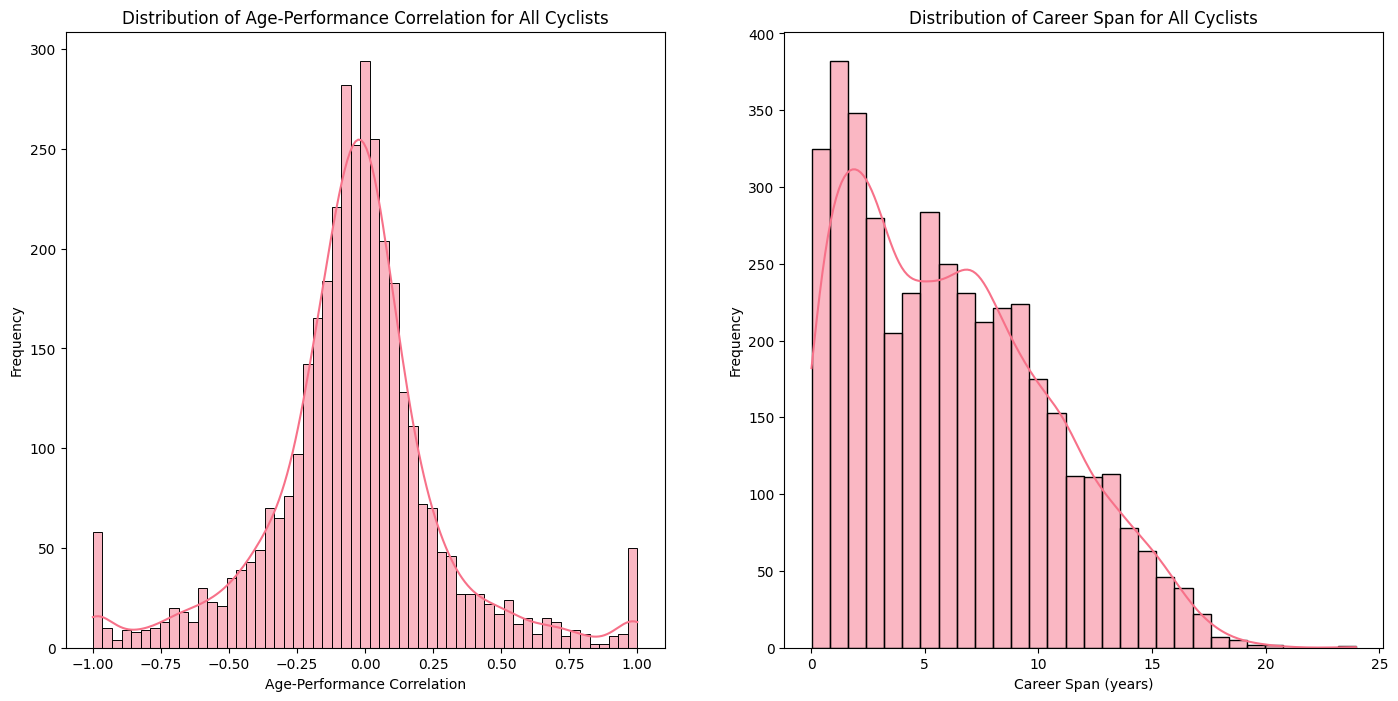

In [139]:
all_cyclists = cs_cor_dr['cyclist'].unique()
progression_data_all_cyclists = [analyze_cyclist_progression(cyclist, cs_cor_dr, plot=False) for cyclist in all_cyclists]
progression_data_all_cyclists = [data for data in progression_data_all_cyclists if data is not None]

prog_df = pd.DataFrame(progression_data_all_cyclists)


# Visualize age-performance correlation for all cyclists
fig = plt.figure(figsize=(17, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = plt.subplot(gs[0, 0])
seaborn.histplot([data['age_performance_correlation'] for data in progression_data_all_cyclists], bins="auto", kde=True)
ax1.set_title('Distribution of Age-Performance Correlation for All Cyclists')
ax1.set_xlabel('Age-Performance Correlation')
ax1.set_ylabel('Frequency')

ax2 = plt.subplot(gs[0, 1])
seaborn.histplot(prog_df['career_span'], bins=30, kde=True)
ax2.set_title('Distribution of Career Span for All Cyclists')
ax2.set_xlabel('Career Span (years)')
ax2.set_ylabel('Frequency')
plt.show()
plt.close(fig)
del prog_df
del cs_cor_dr

The results show a clearly bell-shaped distribution, which isn't surprising. For some, age does hinder performance, but for most, it doesn't.

As regards the histogram of career span, we can see that the distribution is right-skewed, meaning there are very few cyclists with long careers. Surprisingly, the number of riders that have a cycling span between 0 and 3 years is high, which might mean that cycling is a very physically demanding sport.

#### Radar Plot of Physical Attributes of Top Performers by Race Type


In [9]:
tprt_rad_feat = ['name', 'height', 'weight', 'date', 'profile', 'points', 'cyclist_age']

tprt_rad_df = MergedDataset[tprt_rad_feat].copy().dropna(subset=['height', 'weight', 'points'])

# Calculate BMI
tprt_rad_df['bmi'] = tprt_rad_df['weight'] / ((tprt_rad_df['height'] / 100) ** 2)

# Calculate years of experience
tprt_rad_df['career_start'] = tprt_rad_df.groupby('name')['date'].transform('min')
tprt_rad_df['experience'] = (pd.to_datetime(tprt_rad_df['date']) - pd.to_datetime(tprt_rad_df['career_start'])).dt.days / 365.25

# Function to categorize race profile
def categorize_profile(profile):
    if profile < 1.5:
        return 'Flat'
    elif profile < 3:
        return 'Hilly'
    elif profile < 4:
        return 'Mountainous'
    elif profile < 5:
        return 'High Mountainous'
    else:
        return 'Really High Mountainous'

# Add race category to the dataframe
tprt_rad_df['race_category'] = tprt_rad_df['profile'].apply(categorize_profile)

# Function to get top performer for each race category
def get_top_performer(category):
    category_data = tprt_rad_df[tprt_rad_df['race_category'] == category]
    top_cyclist = category_data.groupby('name')['points'].mean().idxmax()
    return category_data[category_data['name'] == top_cyclist].iloc[0]

# Get top performers
top_performers = {
    'Flat': get_top_performer('Flat'),
    'Hilly': get_top_performer('Hilly'),
    'Mountainous': get_top_performer('Mountainous'),
    'High Mountainous': get_top_performer('High Mountainous'),
    'Really High Mountainous': get_top_performer('Really High Mountainous')
}

# Prepare data for radar plot
attributes = ['height', 'weight', 'bmi', 'cyclist_age', 'experience']
data = {category: [cyclist[attr] for attr in attributes] for category, cyclist in top_performers.items()}

# Normalize the data separately for each attribute
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(pd.DataFrame(data, index=attributes).T).T

# Function to create enhanced radar plot using Plotly
def radar_plot(data, title, names):
    fig = go.Figure()

    for i, (category, values) in enumerate(data.items()):
        fig.add_trace(go.Scatterpolar(
            r=values + values[:1],  # Repeat the first value for closure
            theta=attributes + [attributes[0]],  # Repeat the first attribute for closure
            fill='toself',
            name=f"{category} - {names[category]}",
            opacity=0.6,
            marker=dict(size=8)
        ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 2],
                showline=True,
                linewidth=1,
                tickfont=dict(size=10)
            )
        ),
        showlegend=True,
        title=title,
        legend=dict(font=dict(size=12))
    )
    
    return fig

# Create the plot with normalized data and cyclist names
cyclist_names = {category: cyclist['name'] for category, cyclist in top_performers.items()}
fig = radar_plot(dict(zip(top_performers.keys(), normalized_data)), 
                 "Physical Attributes of Top Performers by Race Type", cyclist_names)

# Show the plot
fig.show()
del tprt_rad_feat

We can see that there is a relationship between terrain difficulty and the rider's BMI, which in some cases has a positive impact. It can be said that the more extreme the terrain is, the more tactical experience matters.

#### Race Profile vs Points/UCI points Scatter Plot.

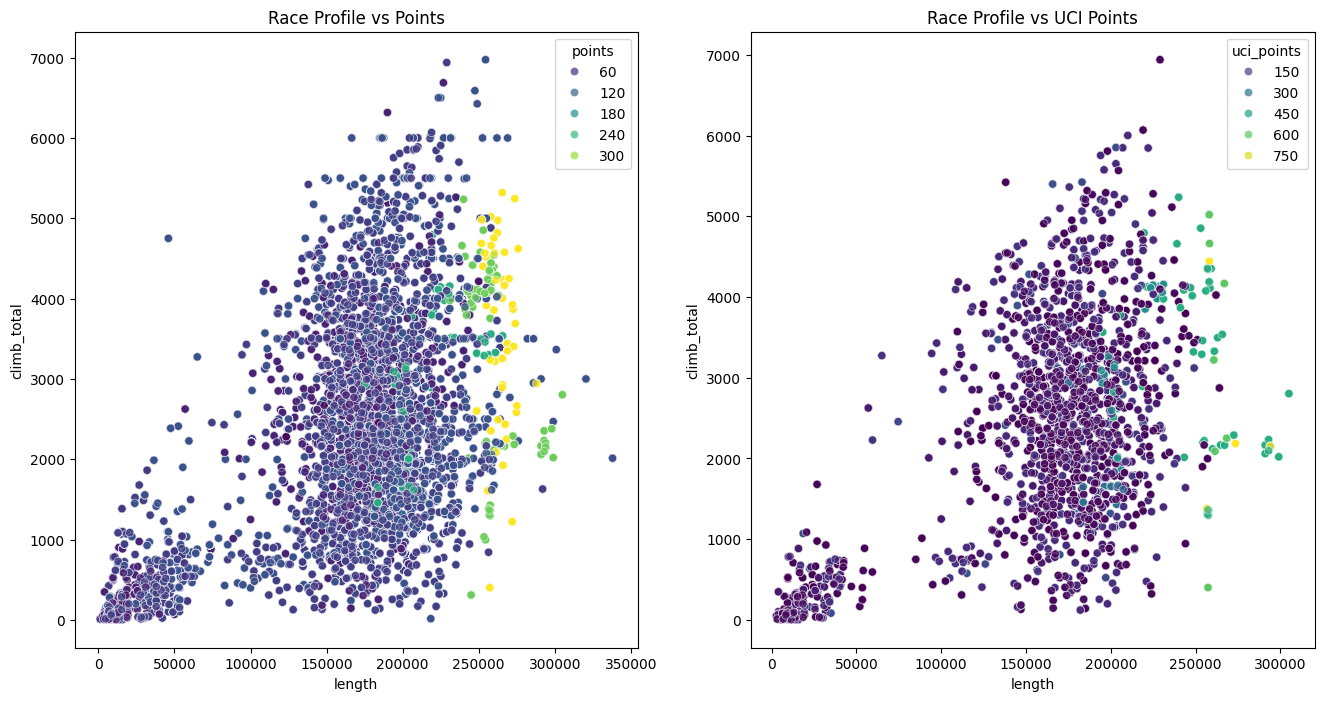

In [140]:
rppu_scat_feat = ['length', 'climb_total', 'points', 'uci_points', 'profile']
rppu_scat_df = MergedDataset[rppu_scat_feat].copy()

# 3.1 Race Profile vs Cyclist Performance
fig = plt.figure(figsize=(16, 8))
gs = plt.GridSpec(1, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
seaborn.scatterplot(x='length', y='climb_total', hue='points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax1.set_title('Race Profile vs Points')


# 3.2 Race Profile vs Cyclist UCI Points
ax2 = fig.add_subplot(gs[0, 1])
seaborn.scatterplot(x='length', y='climb_total', hue='uci_points', data=rppu_scat_df, palette='viridis', alpha=0.7)
ax2.set_title('Race Profile vs UCI Points')


plt.show()
plt.close()
del rppu_scat_feat

We can see the correlation between `points` and `uci_points`, as the scatter plots are very similar. The only notable difference is that `uci_points` tend to have higher values. Additionally, `uci_points` are more selective, with fewer high-point races compared to the general point system. However, this might be due to the fact that we have fewer `uci_points` values.

We can observe a trend where longer races with more climbing tend to award more points. These plots show that to earn high points, cyclists need to excel in both endurance and climbing ability. Riders in very short flat races have fewer opportunities for high point gains.

#### Tarmac vs Points/UCI Points and Profiles vs Points/UCI points box plots

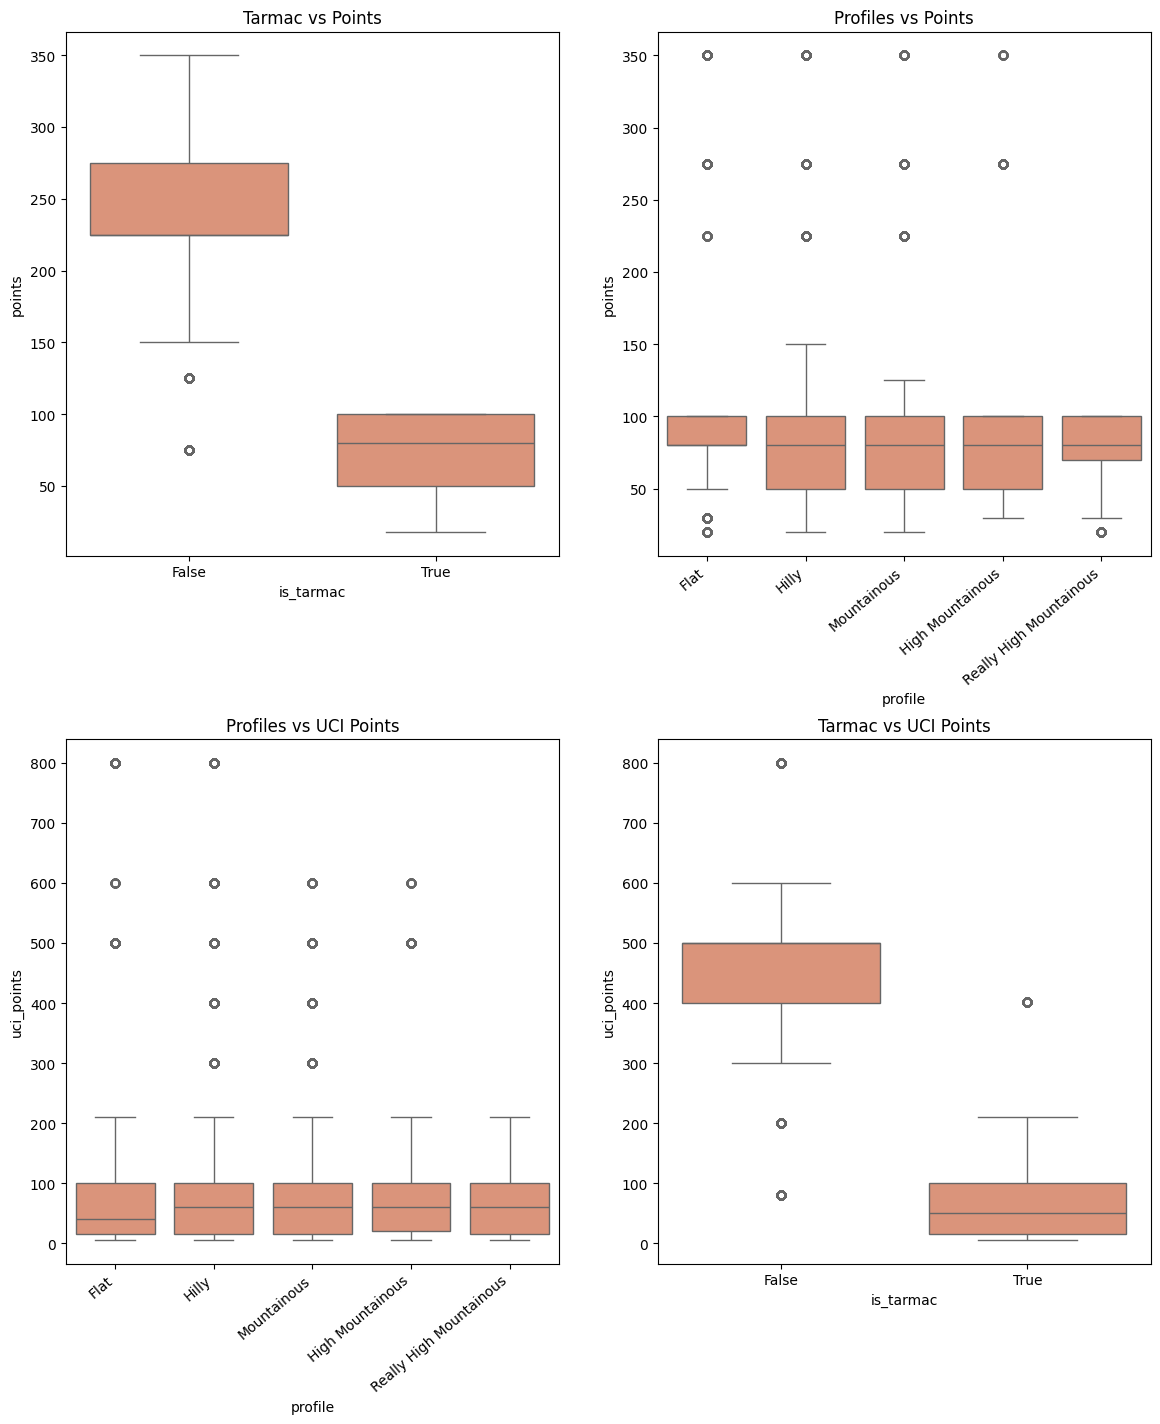

In [177]:
seaborn.color_palette("pastel")

tpu_box_feat = ['is_tarmac', 'profile', 'points', 'uci_points']
tpu_box_dr = MergedDataset[tpu_box_feat].copy()


fig = plt.figure(figsize=(14, 16))
gs = plt.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.35)

ax1 = fig.add_subplot(gs[0, 0])
profiles = seaborn.boxplot(x='is_tarmac', y='points', data=tpu_box_dr, ax=ax1)
ax1.set_title('Tarmac vs Points')


ax2 = fig.add_subplot(gs[0, 1])
profiles = seaborn.boxplot(x='profile', y='points', data=tpu_box_dr, ax=ax2)
profiles.set_xticks(profiles.get_xticks())
profiles.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax2.set_title('Profiles vs Points')
plt.xticks(rotation=40, ha='right',horizontalalignment='right')



# 5.2 Race Surface vs Cyclist UCI Points

ax3 = fig.add_subplot(gs[1, 1])
profiles = seaborn.boxplot(x='is_tarmac', y='uci_points', data=tpu_box_dr, ax=ax3)
ax3.set_title('Tarmac vs UCI Points')

ax4 = fig.add_subplot(gs[1, 0])
profiles = seaborn.boxplot(x='profile', y='uci_points', data=tpu_box_dr, ax=ax4)
ax4.set_xticks(profiles.get_xticks())
ax4.set_xticklabels(['Flat', 'Hilly', 'Mountainous', 'High Mountainous', 'Really High Mountainous'])
ax4.set_title('Profiles vs UCI Points')


plt.xticks(rotation=40, ha='right',horizontalalignment='right')
# plt.tight_layout()
plt.show()
plt.close()



The analysis of box plots comparing points and UCI points across tarmac, non-tarmac, and race profiles reveals a structured scoring system that values versatility across terrains and disciplines. In both systems, non-tarmac events—likely off-road or mountain bike races—award significantly higher points, with medians around 225 and 450 for points and UCI points, respectively, compared to lower values for tarmac races. This indicates a greater emphasis on non-tarmac disciplines, potentially to encourage participation. 

Across profiles, points are fairly similar, with medians generally between 75-100 points, though flat and extreme mountainous profiles (like "Really High Mountainous") show slightly higher medians. Outliers with much higher points in each category likely represent prestigious events, such as key stages in Grand Tours or significant classics. 

The variability within profiles, especially in hilly and mountainous categories, suggests a range of race difficulties. Flat races, although often standardized, still hold a respectable median value, while high mountainous profiles don’t always award the highest average points, yet include notable outliers. The scoring structure encourages cyclists to compete across various race types, with specialization still possible in specific profiles or terrains. 

For the UCI points specifically, the balanced distribution across race profiles on tarmac suggests an effort to value different road racing profiles equally, while the prominent role of non-tarmac events highlights a focus on promoting diverse cycling disciplines. Overall, both systems seem aimed at fostering well-rounded cyclists capable of excelling across different terrains, while also highlighting prestigious events within each category.

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

### Missing values distributions

                     Total values  Missing values  Usable values
Elements                                                        
_url                       589865               0         589865
name                       589865               0         589865
points                     589865             477         589388
uci_points                 589865          338779         251086
length                     589865               0         589865
climb_total                589865          147045         442820
profile                    589865          148194         441671
startlist_quality          589865               0         589865
average_temperature        589865          559932          29933
date                       589865               0         589865
position                   589865               0         589865
cyclist                    589865               0         589865
cyclist_age                589865             113         589752
is_tarmac                

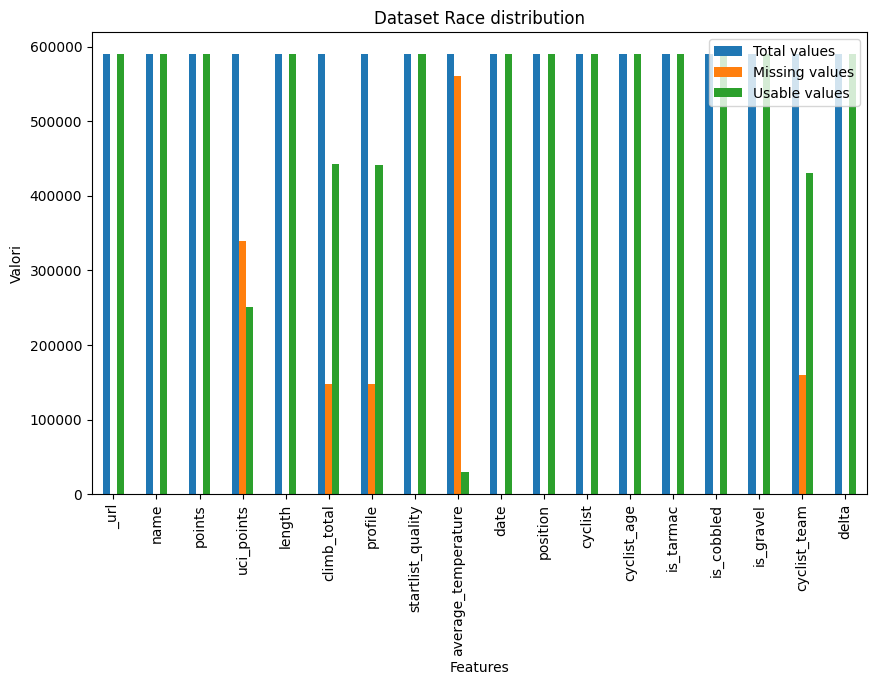

In [36]:
PlotMissingUsableData(DatasetRace, "Race")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

### Features distributions

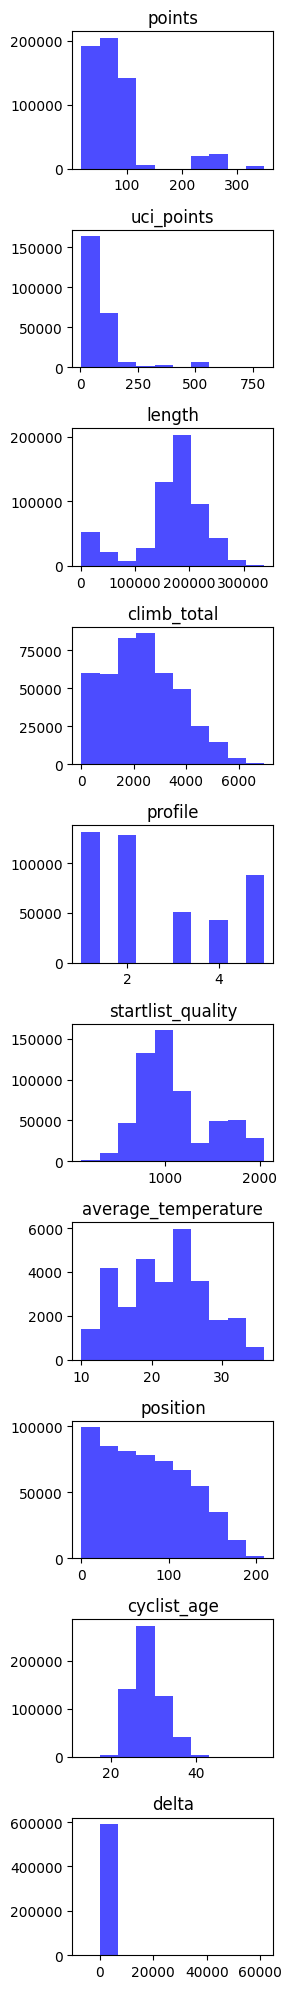

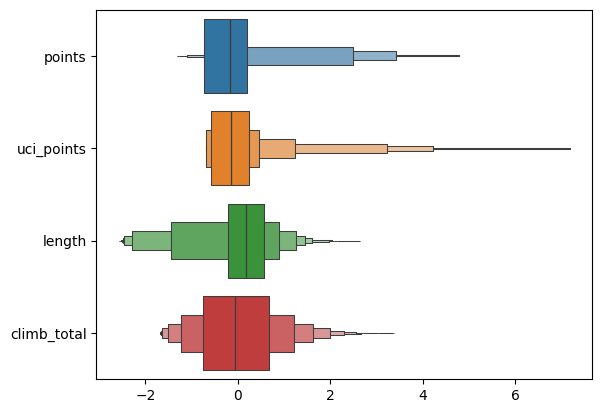

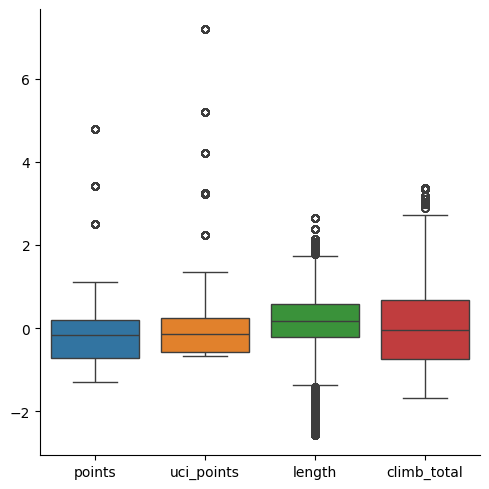

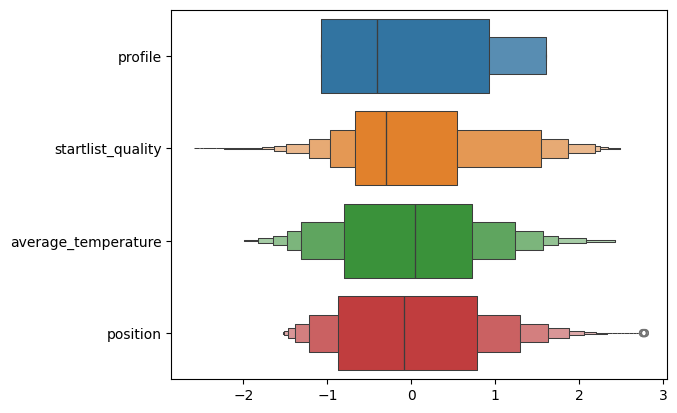

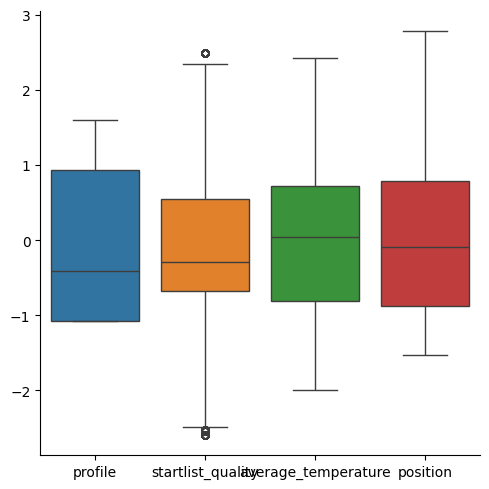

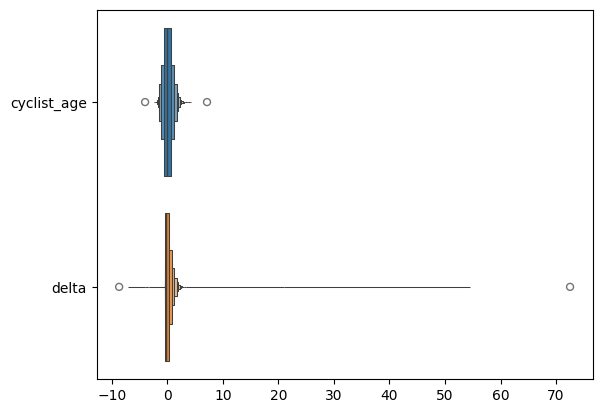

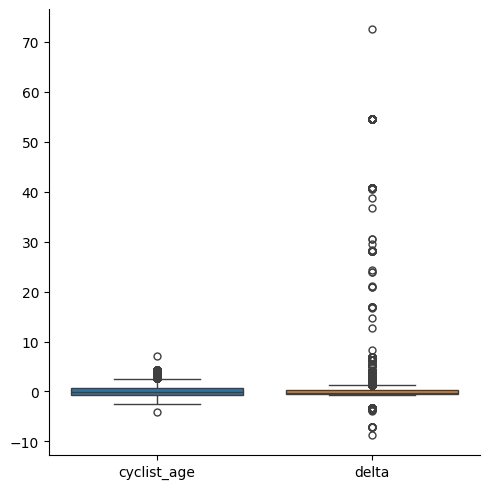

In [37]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

### Correlations between features (Oleskiy)

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data cleaning**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [38]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

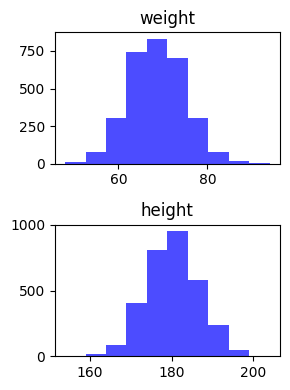

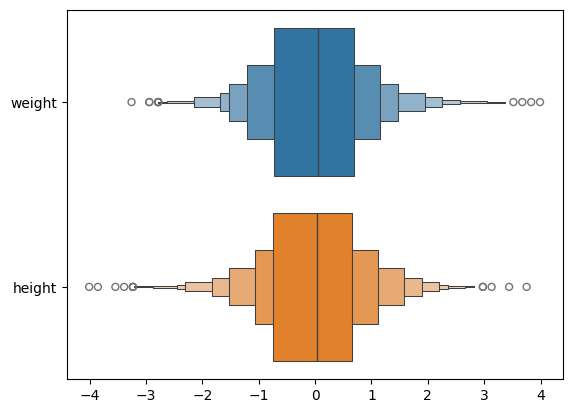

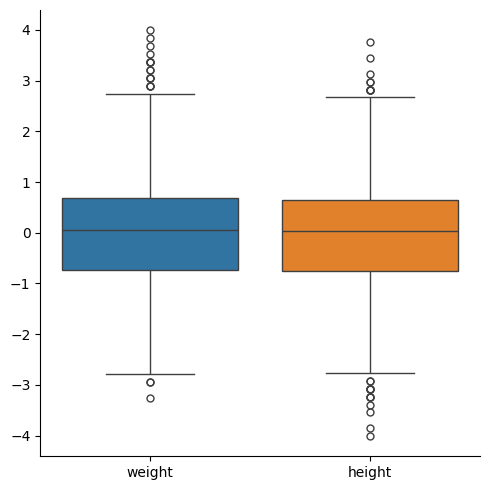

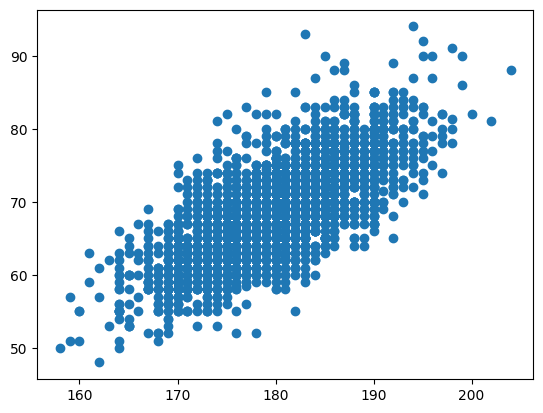

In [39]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [40]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

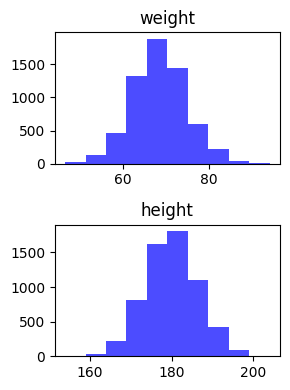

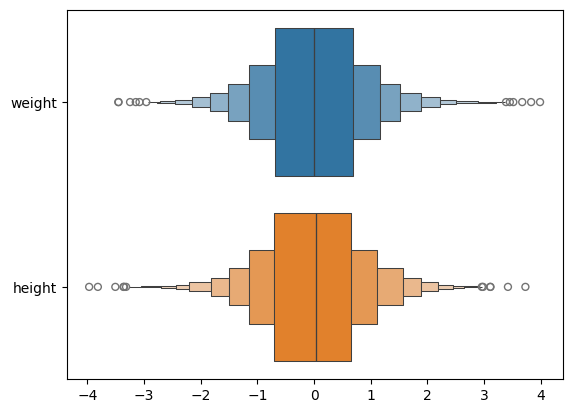

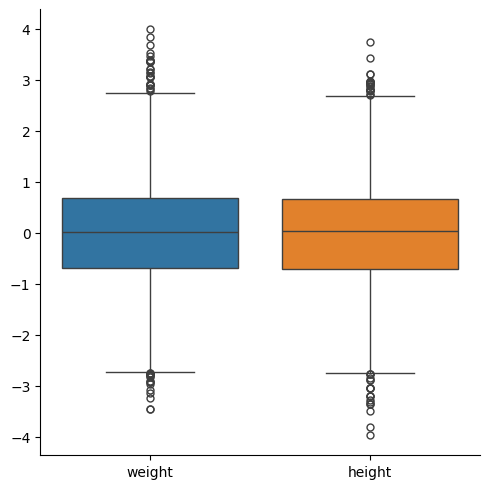

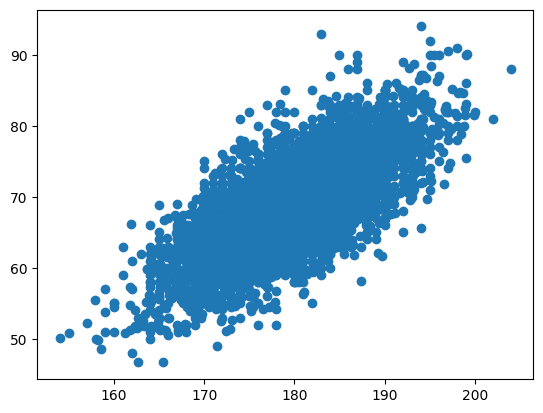

In [41]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

### View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


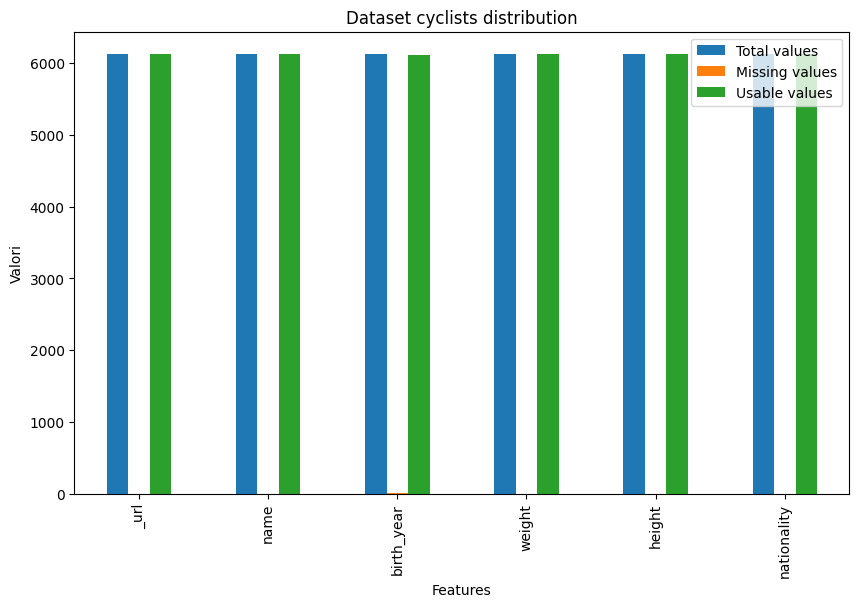

In [42]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [43]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Fill data of climb_total and profile columns (Oleskiy)

### Fill data of points and uci_points columns (Oleskiy)

### Fill data of cyclists_age and cyclists_team columns (Riccardo)

### View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     589865               0         589865
name                     589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0         589865
cyclist                  589865               0         589865
cyclist_age              589865             113         589752
is_tarmac                589865               0         589865
is_cobbled               589865               0        

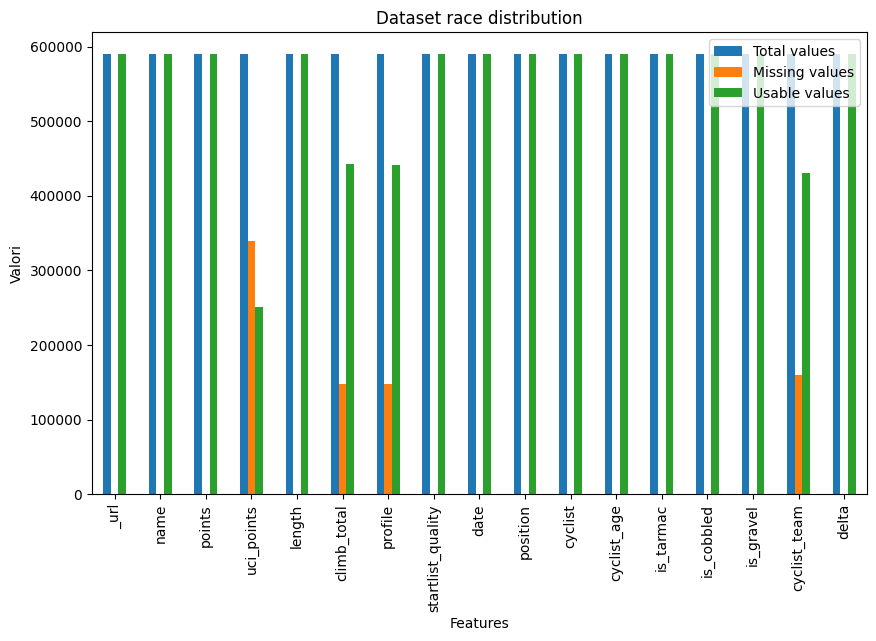

In [44]:
PlotMissingUsableData(DatasetRace, "race")

# **Feature engineering**

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             589865               0         589865
birth_year               589865             113         589752
weight                   589865               0         589865
height                   589865               0         589865
nationality              589865               0         589865
name_race                589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0        

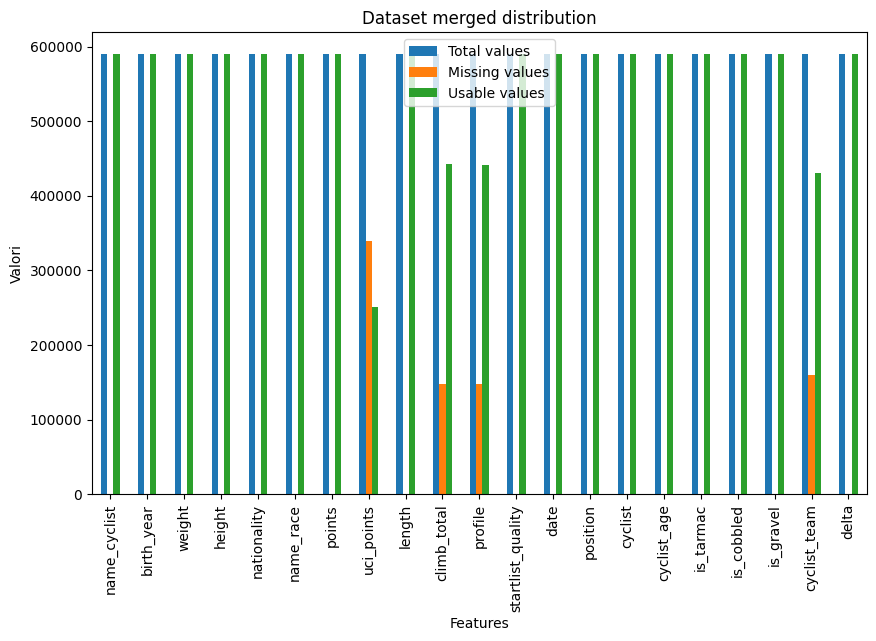

In [45]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")

# - (Analysis a choosed situation)